In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import time
import json
import glob
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [4]:
import sys
sys.path.append('../')
from fog_dataloader import FogDataloader as fog
from models import multiview_vit as vit
from utils import SparkMET as sm
from utils import engine
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Check if there is GPU(s): {torch.cuda.is_available()}")

Check if there is GPU(s): True


### Reliability Diagram 

In [8]:
df_test = pd.read_csv(os.path.join(SaveDir, Exp_name, 'test_prob_' + Exp_name + '.csv'), index_col= 0)
df_test

,date_time,round_time,date_cycletime,vis,ytrue,fog_preb,nonfog_preb
0,20180530 05:55:00,20180530 06:00:00,20180530_0000,10.0,0,1.619913e-07,1.0
1,20180530 11:55:00,20180530 12:00:00,20180530_0600,10.0,0,6.030654e-08,1.0
2,20180530 17:55:00,20180530 18:00:00,20180530_1200,10.0,0,9.606407e-11,1.0
3,20180530 23:55:00,20180531 00:00:00,20180530_1800,10.0,0,8.914791e-11,1.0
4,20180531 05:55:00,20180531 06:00:00,20180531_0000,10.0,0,3.810993e-09,1.0
...,...,...,...,...,...,...,...
2223,20200527 23:55:00,20200528 00:00:00,20200527_1800,10.0,0,2.051478e-13,1.0
2224,20200529 05:55:00,20200529 06:00:00,20200529_0000,10.0,0,1.851328e-13,1.0
2225,20200529 11:55:00,20200529 12:00:00,20200529_0600,10.0,0,6.410800e-12,1.0
2226,20200529 17:55:00,20200529 18:00:00,20200529_1200,10.0,0,1.418918e-09,1.0


Text(0.5, 1.0, 'n_bins=10')

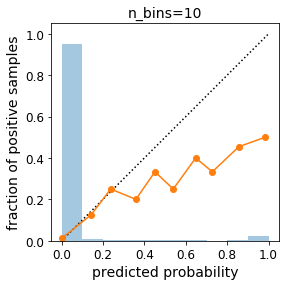

In [10]:
from sklearn.calibration import calibration_curve
def plot_calibration_curve(y_true, y_prob, n_bins=10, ax=None, hist=True, normalize=False):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, normalize=normalize)
    if ax is None:
        ax = plt.gca()
    if hist:
        ax.hist(y_prob, weights=np.ones_like(y_prob) / len(y_prob), alpha=.4,
               bins=np.maximum(10, n_bins))
    ax.plot([0, 1], [0, 1], ':', c='k')
    curve = ax.plot(prob_pred, prob_true, marker="o")

    ax.set_xlabel("predicted probability")
    ax.set_ylabel("fraction of positive samples")

    ax.set(aspect='equal')
    return curve

    
plot_calibration_curve(df_test.ytrue, df_test.fog_preb)
plt.title("n_bins=10")

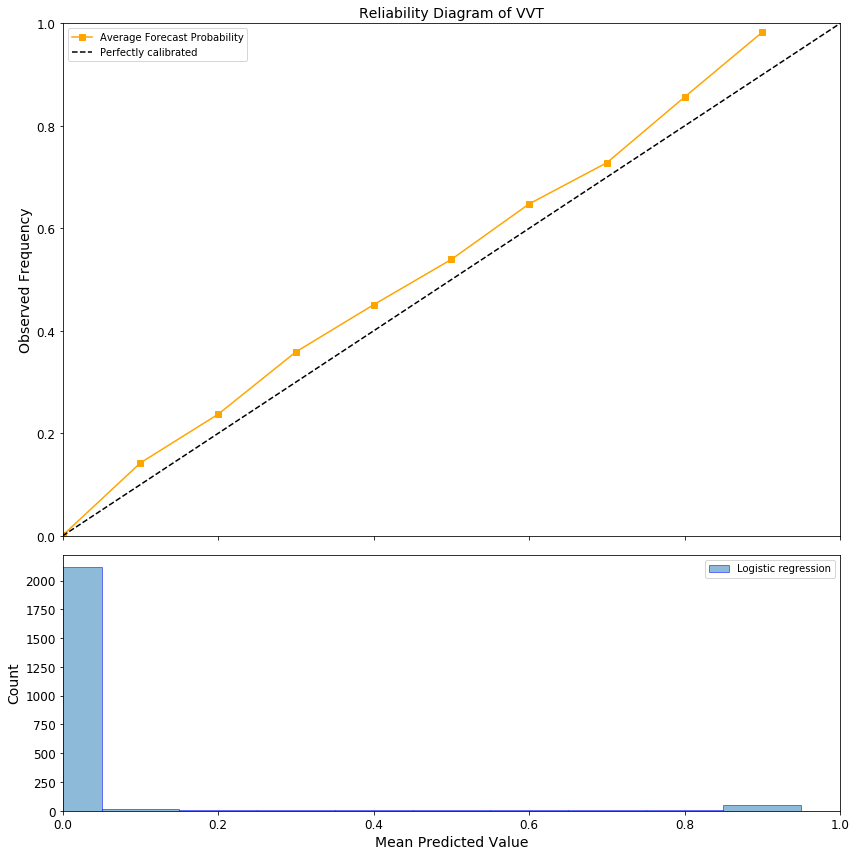

In [21]:
forecasted_probabilities = np.array(df_test['fog_preb'])  
actual_occurrences = np.array(df_test['ytrue']) 

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

bins = np.linspace(0, 1, num=11)  # 10 bins

digitized = np.digitize(forecasted_probabilities, bins=bins, right=True)
observed_frequency = np.array([actual_occurrences[digitized == i].mean() for i in range(len(bins)-1)])
average_forecast_probability = np.array([forecasted_probabilities[digitized == i].mean() for i in range(1, len(bins))])

ax1.plot(bins[:-1], average_forecast_probability, 's-', color='orange', label='Average Forecast Probability')
ax1.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
ax1.set_ylabel('Observed Frequency')
ax1.set_title('Reliability Diagram of VVT')
ax1.legend(loc='best')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.grid(False)


bin_counts = np.array([len(forecasted_probabilities[digitized == i]) for i in range(1, len(bins))])

ax2.bar(bins[:-1], bin_counts, width=np.diff(bins), edgecolor='blue', alpha=0.5, label='Logistic regression')
ax2.set_xlabel('Mean Predicted Value')
ax2.set_ylabel('Count')
ax2.legend(loc='best')
ax2.grid(False)

plt.tight_layout()
plt.show()


In [1]:
from sklearn.calibration import calibration_curve
y, x = calibration_curve(np.array(df_test['ytrue']), np.array(df_test['fog_prob']), n_bins = 10)

NameError: name 'np' is not defined

In [195]:
x

array([8.87542277e-04, 1.42292850e-01, 2.37296395e-01, 3.58947332e-01,
       4.50945156e-01, 5.39420198e-01, 6.47689090e-01, 7.28147200e-01,
       8.56364025e-01, 9.82947239e-01])

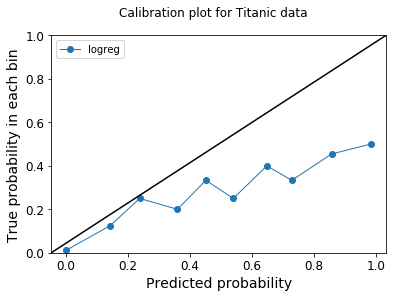

In [196]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(x,y, marker='o', linewidth=1, label='logreg')


# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for Titanic data')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
ax.set_ylim(0, 1)
plt.legend()
plt.show()

In [156]:
# Taken from: https://github.com/Big-Life-Lab/partial-AUC-C/blob/main/Python3.7/do_pAUCc.py
def concordant_partial_AUC(pfpr, ptpr):
    ''' Computes the concordant partial area under the curve and alternatives, given arrays of \n
    "partial fpr" and "partial tpr" values.  These arrays only contain points on the partial curve \n
    and the trapezoidal rule is used to compute areas with these points. \n
    \n
    pAUCc:      the concordant partial area under the curve \n
    pAUC:       the (vertical) partial area under the curve \n
    pAUCx:      the horizontal partial area under the curve \n
    pAUCc_norm: the concordant partial area under the curve normalized \n
    pAUC_norm:  the (vertical) partial area under the curve normalized \n
    pAUCx_norm: the horizontal partial area under the curve normalized \n
    '''

    # xrange [a,b]
    a    = float(pfpr[0])
    b    = float(pfpr[-1])
    delx = b - a
    vertical_stripe_area = (1 * delx)

    # yrange [f,g]
    f    = float(ptpr[0])
    g    = float(ptpr[-1])
    dely = g - f
    horizontal_stripe_area = (dely * 1)

    if delx == 0:
        print("Warning: For pAUC and pAUCc the width (delx) of the vertical column is zero.")
        pAUC  = 0
        pAUCn = 0
        sPA   = 0
    else:
        # Compute the partial AUC mathematically defined in (Dodd and Pepe, 2003) and conceptually defined in
        #   (McClish, 1989; Thompson and Zucchini, 1989). Use the trapezoidal rule to compute the integral.
        pAUC  = np.trapz(ptpr, pfpr)  # trapz is y,x
        pAUCn = pAUC / vertical_stripe_area
    #endif

    if dely == 0:
        print("Warning: For pAUCx and pAUCc the height (dely) of the horizontal stripe is zero.")
        pAUCx  = 0
        pAUCxn = 0
    else:
        # Compute the horizontal partial AUC (pAUCx) defined in (Carrington et al, 2020) and as
        # suggested by (Walter, 2005) and similar to the partial area index (PAI)
        # (Nishikawa et al, ?) although PAI has a fixed right boundary instead and a slightly
        # different mathematical definition.
        #
        # Normally we would compute the area to the right of the curve, the horizontal integral,
        # as follows:
        #   1. swap the axes
        #   2. flip the direction of the new vertical
        #   3. compute the (vertical) integral
        #
        tempX  = ptpr                      # swap the axes
        tempY  = list(1 - np.array(pfpr))  # flip the direction
        pAUCx  = np.trapz(tempY, tempX)    # trapz is y,x
        pAUCxn = pAUCx / horizontal_stripe_area
    #endif

    total_for_norm = vertical_stripe_area + horizontal_stripe_area
    if total_for_norm == 0:
        pAUCc  = 0
        pAUCcn = 0
        print('Warning: Zero length partial curve specified.')
    else:
        pAUCc  = (1/2)*pAUCx + (1/2)*pAUC  # the complexity is in the derivation, meaning/generalization
        #   and relation to the c and partial c statistic, not the
        #   formula which looks like a simple average
        #pAUCcn= (pAUCx + pAUC) / total_for_norm
        if vertical_stripe_area > 0 and horizontal_stripe_area > 0: # NEW part-wise normalization
            pAUCcn = (1 / 2) * (pAUC  / vertical_stripe_area) + (1 / 2) * (pAUCx / horizontal_stripe_area)
        elif pAUCn == 1:
            pAUCcn = 1 # best case scenario
        elif vertical_stripe_area   == 0:
            pAUCcn = (1 / 2) * (pAUCx / horizontal_stripe_area)
        elif horizontal_stripe_area == 0:
            pAUCcn = (1 / 2) * (pAUC  / vertical_stripe_area)
        # endif
    #endif
    
    sPA = 0.5*(1+ (pAUC - (pfpr[-1]**2)/2)/ (pfpr[-1] - (pfpr[-1]**2)/2))  # One the use of partial AUC. Hua Ma et all
    
    return pAUCc, pAUC, pAUCx, pAUCcn, pAUCn, pAUCxn, sPA

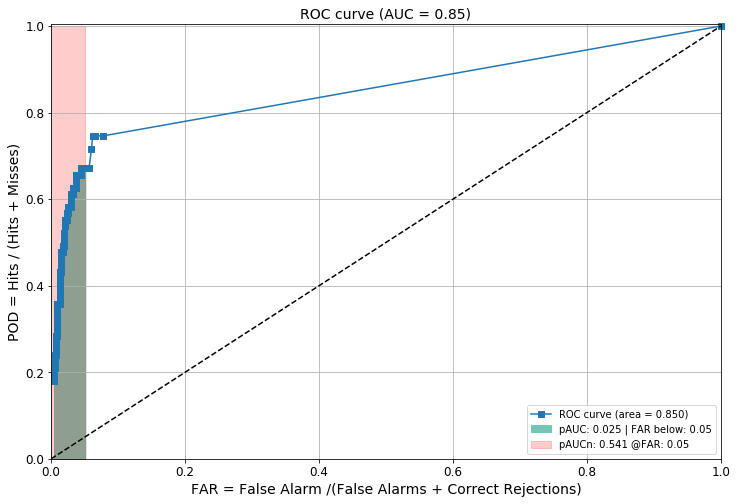

In [189]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_pod_far(y_true, y_prob):
    # Initialize variables
    pods = []
    fars = []
    thresholds = np.arange(0, 1, 0.001)
    for i in thresholds:
        pred_classes = y_prob[:, None] >= i
        CR, FA, MISS, Hit = confusion_matrix(y_true, pred_classes).ravel()
        POD  = Hit/(Hit+MISS)
        F    = FA/(FA+CR)
        pods.append(POD)
        fars.append(F)
    return pods, fars

PODs, FARs = calculate_pod_far(df_test.ytrue, df_test.fog_prob)
roc_data = {"POD": PODs, "FAR": FARs}
roc_df_logit = pd.DataFrame(roc_data).sort_values(by = ["POD", "FAR"])


far_cutoff = 0.05
idx = np.where(np.array(roc_df_logit["FAR"])>far_cutoff)[0].min()
idx+=1
pAUCc, pAUC, pAUCx, pAUCcn, pAUCn, pAUCxn, sPA = concordant_partial_AUC(np.array(roc_df_logit["FAR"])[:idx], 
                                                                        np.array(roc_df_logit["POD"][:idx]))


#Integrate under ROC curve to get AUC
auc = np.trapz(roc_df_logit["POD"], roc_df_logit["FAR"])
fig, ax = plt.subplots(figsize=(12, 8))
#Plot figure
ax.plot(roc_df_logit["FAR"], roc_df_logit["POD"], 's-',  
        label='ROC curve (area = {0:.2f})'.format(auc), 
        clip_on = False)

ax.fill_between(roc_df_logit["FAR"][:idx], roc_df_logit["POD"][:idx], color='#73C6B6', 
                label=f'pAUC: {pAUC:0.3f} | FAR below: {far_cutoff:0.2f}')
ax.fill_between([0, far_cutoff], [1, 1], color='r', 
                label=f'pAUCn: {pAUCn:0.3f} @FAR: {far_cutoff:0.2f}', alpha=0.2)


ax.plot([0, 1], [0, 1], color = 'k', linestyle = '--')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.005])
ax.set_xlabel('FAR = False Alarm /(False Alarms + Correct Rejections)')
ax.set_ylabel('POD = Hits / (Hits + Misses)')
ax.set_title('ROC curve (AUC = %.2f)'%auc)
ax.legend(loc ="lower right")
ax.grid(True)
plt.show()

In [125]:
_ = Evaluation(df, df_test, by = 'HSS', report_file_name = '/data1/fog/SparkMET/EXPs/Finals/report.txt', figure_name = 'fig.pnf')._return_report()

### Cross Validation 

#### Return the quantitative report

In [ ]:
exp_dir = '/data1/fog/SparkMET/EXPs/Nov11_Cv2_VVT_Final/'
test_mean_df = engine._return_mean_prob_cvs(exp_dir)
test_mean_df

In [20]:
train_df = pd.read_csv('/data1/fog/Hamid/SparkMET/EXPs/Nov11_Cv2_VVT_Final/vvt_32_1024_512_8_6_0001_01_30_cv2_8/train_prob_vvt_32_1024_512_8_6_0001_01_30_cv2_8.csv', index_col=0)
_ = engine.Evaluation(train_df, test_mean_df, by = 'HSS', 
                      report_file_name = '/data1/fog/SparkMET/EXPs/Nov11_Cv2_VVT_Final/report3.txt', 
                      figure_name = 'fig.pnf')._return_report()

#### Visualize Attention Scores

In [7]:
data_loader_training, data_loader_validate, data_loader_testing = fog.Fog_DataLoader_npz_cv(batch_size = 32, 
                                                                                            kfold_id  = 8, 
                                                                                            SaveDir = '/data1/fog/Hamid/SparkMET/EXPs/Nov11_Cv2_VVT_Final/', 
                                                                                            Exp_name = 'vvt_32_1024_512_8_6_0001_01_30_cv2_8', 
                                                                                            WeightR = False)

#================================ Summary of Dataset ==================#
number of training samples:   7960 | number of training fog cases:   141
number of validation samples: 828 | number of validation fog cases: 15
number of test samples:       2228 | number of test fog cases:       67
#======================================================================#


In [20]:
config = sm.Get_model_config( img_size = 32, in_channel = 388, in_time = 4, embd_size = 1024, mlp_size = 512, 
                                      num_heads = 8, dropout = 0.2, num_layers  = 6, conv_type = '2d', embd_type = 'VVT').return_config()

FogNet = sm.SparkMET(config, 
                           SaveDir = '/data1/fog/Hamid/SparkMET/EXPs/Nov11_Cv2_VVT_Final/', 
                           Exp_Name = 'vvt_32_1024_512_8_6_0001_01_30_cv2_8')

model, optimizer, loss_func = FogNet.compile(optmizer = 'adamw', loss = 'BCE', lr = 0.0001, wd = 0.01)

The number of model's parameters = 56970242


In [ ]:
df, vvt_att_out, input_maps = FogNet.inference(model, data_loader_training)

print(f"input maps: {input_maps.shape} | att_maps: {vvt_att_out.shape}")

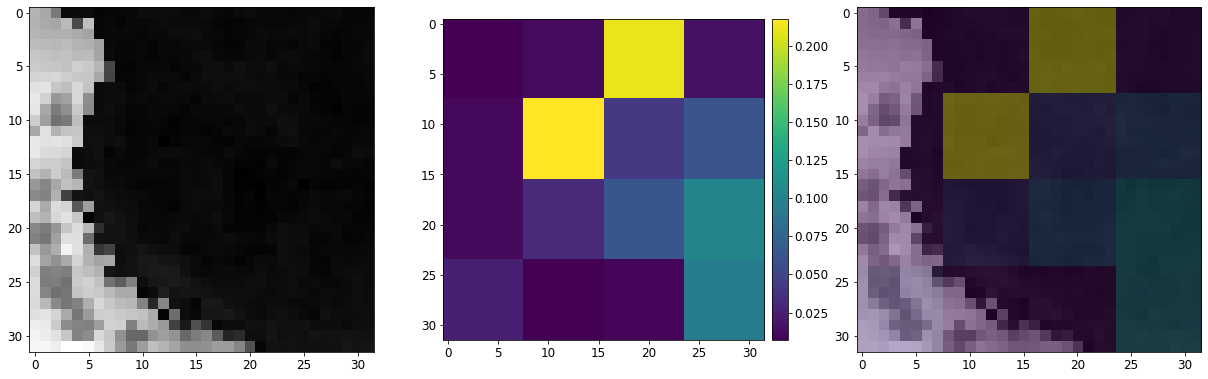

In [11]:
_ = engine.single_spatial_att_map(df, input_maps, vvt_att_out, global_case = 'Hit', local_date = None, head_avg = False)

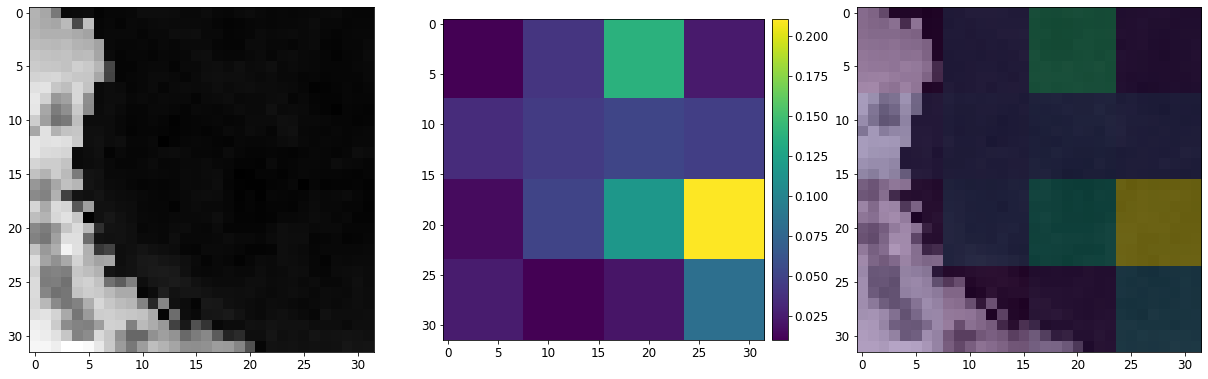

In [12]:
_ = engine.single_spatial_att_map(df, input_maps, vvt_att_out, global_case = 'Miss', local_date = None, head_avg = False)

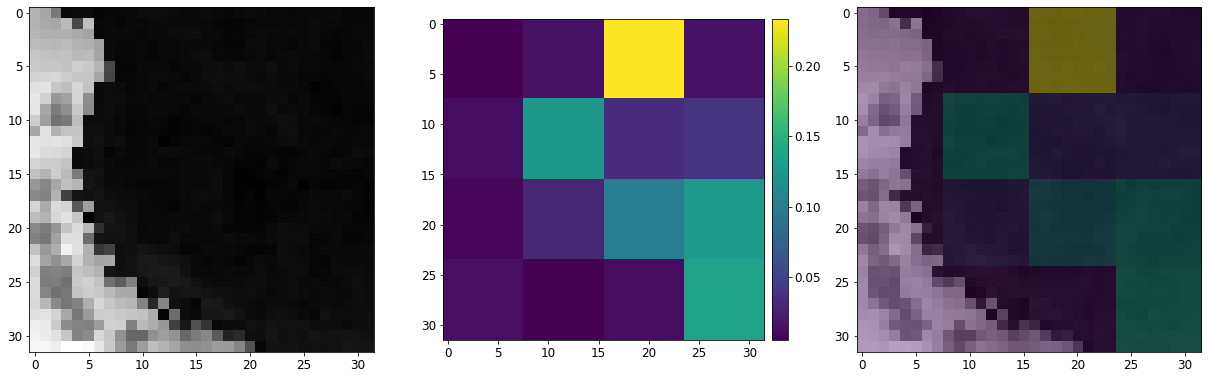

In [13]:
_ = engine.single_spatial_att_map(df, input_maps, vvt_att_out, global_case = 'FA', local_date = None, head_avg = False)

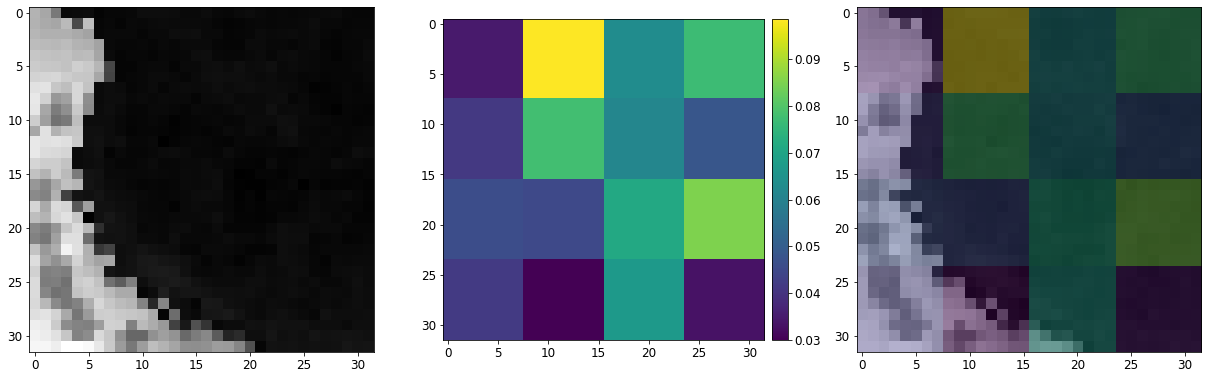

: 

In [14]:
_ = engine.single_spatial_att_map(df, input_maps, vvt_att_out, global_case = 'CR', local_date = None, head_avg = False)

In [40]:
### Hit cases: 
hit_cases = train_df[(train_df['ytrue'] == 1) & (train_df['fog_prob'] >= 0.52)]
hit_cases[50:60]

,date_time,round_time,date_cycletime,vis,ytrue,fog_prob,nonfog_prob
3925,20120201 17:55:00,20120201 18:00:00,20120201_1200,0.25,1,0.952516,0.047484
4121,20150121 11:55:00,20150121 12:00:00,20150121_0600,0.50,1,0.856329,0.143671
4235,20100403 12:05:00,20100403 12:00:00,20100403_0600,0.25,1,0.647420,0.352580
4263,20120123 05:55:00,20120123 06:00:00,20120123_0000,0.25,1,0.918872,0.081128
4311,20120224 05:55:00,20120224 06:00:00,20120224_0000,0.50,1,0.960936,0.039064
4374,20140226 05:55:00,20140226 06:00:00,20140226_0000,0.50,1,0.887594,0.112405
4425,20131118 11:55:00,20131118 12:00:00,20131118_0600,1.00,1,0.963190,0.036810
4458,20150317 05:55:00,20150317 06:00:00,20150317_0000,0.25,1,0.969912,0.030088
4652,20120313 05:55:00,20120313 06:00:00,20120313_0000,0.25,1,0.996515,0.003485
4689,20140301 11:55:00,20140301 12:00:00,20140301_0600,1.00,1,0.931736,0.068264


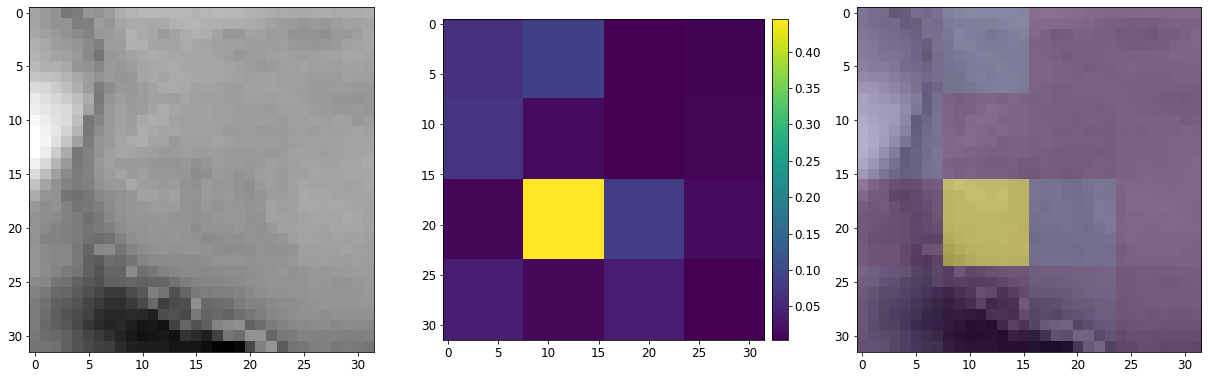

In [41]:
_ = engine.single_spatial_att_map(train_df, input_maps, vvt_att_out, 
                                  variable = 93, 
                                  date = '20150317_0000', head_avg = False)

In [19]:
### Miss cases: 
miss_cases = train_df[(train_df['ytrue'] == 1) & (train_df['fog_prob'] < 0.52)]
miss_cases

,date_time,round_time,date_cycletime,vis,ytrue,fog_prob,nonfog_prob
122,20090419 06:05:00,20090419 06:00:00,20090419_0000,0.50,1,0.113574,0.886426
130,20091214 00:05:00,20091214 00:00:00,20091213_1800,0.25,1,0.005803,0.994197
440,20161228 23:55:00,20161229 00:00:00,20161228_1800,0.25,1,0.491064,0.508936
683,20140209 11:55:00,20140209 12:00:00,20140209_0600,0.50,1,0.141451,0.858549
1079,20100107 12:00:00,20100107 12:00:00,20100107_0600,0.25,1,0.431169,0.568831
1082,20151208 11:55:00,20151208 12:00:00,20151208_0600,0.25,1,0.500000,0.500000
1389,20140218 11:55:00,20140218 12:00:00,20140218_0600,0.50,1,0.484078,0.515922
1471,20141205 11:55:00,20141205 12:00:00,20141205_0600,0.75,1,0.399387,0.600613
1558,20131216 11:55:00,20131216 12:00:00,20131216_0600,0.25,1,0.000294,0.999706
1645,20140406 05:55:00,20140406 06:00:00,20140406_0000,1.00,1,0.480519,0.519481


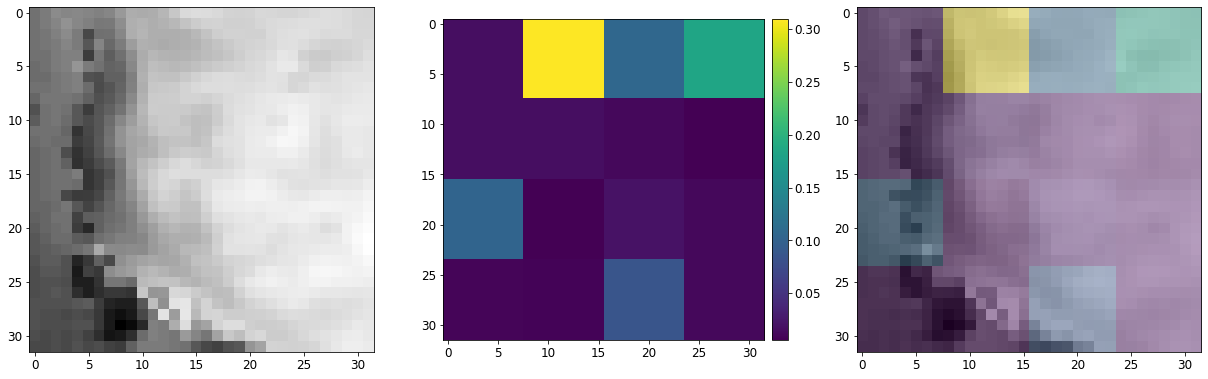

In [26]:
_ = engine.single_spatial_att_map(train_df, input_maps, vvt_att_out, 
                                  variable = 93, 
                                  date = '20150321_0000', head_avg = False)

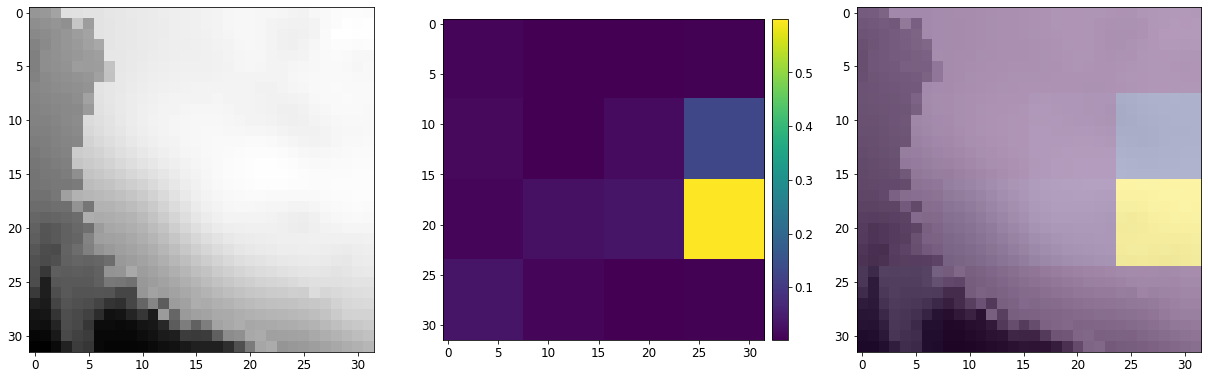

In [20]:
_ = engine.single_spatial_att_map(train_df, input_maps, vvt_att_out, 
                                  variable = 93, 
                                  date = '20161216_1200', head_avg = False)

In [21]:
false_alarms = train_df[(train_df['ytrue'] == 0) & (train_df['fog_prob'] >= 0.52)]
false_alarms

,date_time,round_time,date_cycletime,vis,ytrue,fog_prob,nonfog_prob
290,20120214 05:55:00,20120214 06:00:00,20120214_0000,9.0,0,0.688611,0.311389
528,20160412 11:55:00,20160412 12:00:00,20160412_0600,4.0,0,0.676573,0.323427
1091,20120323 11:55:00,20120323 12:00:00,20120323_0600,10.0,0,0.835979,0.164021
1776,20160316 05:55:00,20160316 06:00:00,20160316_0000,2.5,0,0.903790,0.096210
1878,20120222 05:55:00,20120222 06:00:00,20120222_0000,10.0,0,0.564324,0.435676
1946,20160302 11:55:00,20160302 12:00:00,20160302_0600,7.0,0,0.778241,0.221759
2052,20151224 11:55:00,20151224 12:00:00,20151224_0600,4.0,0,0.766489,0.233511
2684,20150404 05:55:00,20150404 06:00:00,20150404_0000,5.0,0,0.651531,0.348470
2797,20090327 06:05:00,20090327 06:00:00,20090327_0000,2.5,0,0.738093,0.261907
2828,20150317 17:55:00,20150317 18:00:00,20150317_1200,10.0,0,0.542701,0.457299


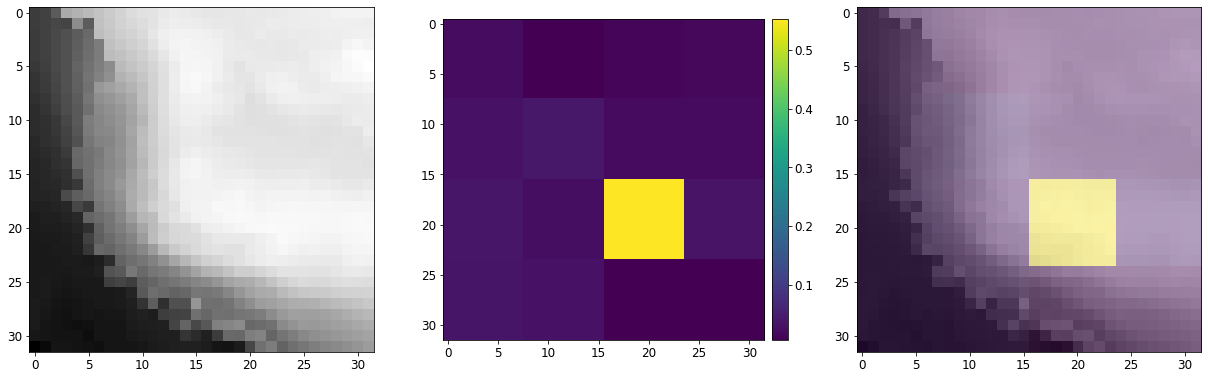

In [22]:
_ = engine.single_spatial_att_map(train_df, input_maps, vvt_att_out, 
                                  variable = 93, 
                                  date = '20141223_0000', head_avg = False)

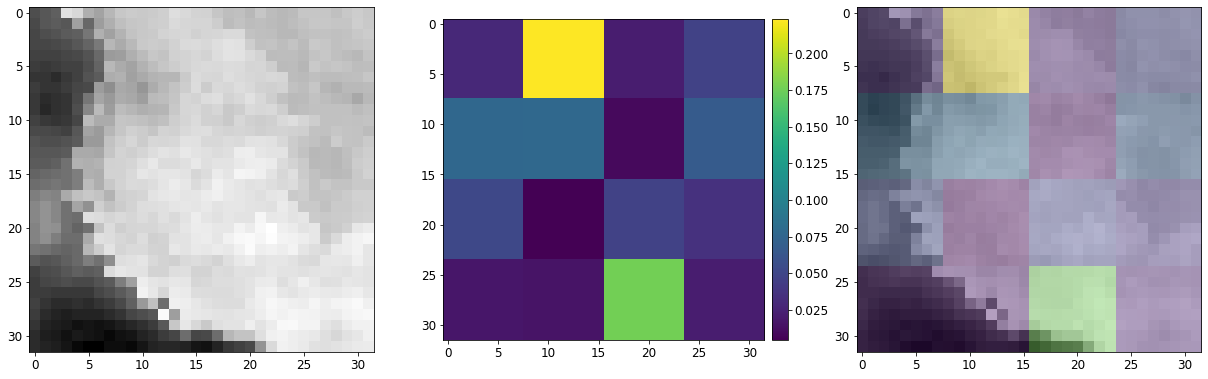

In [42]:
_ = engine.single_spatial_att_map(train_df, input_maps, vvt_att_out, 
                                  variable = 93, 
                                  date = '20150321_0600', head_avg = False)